# Set up


In [1]:
!pip install meshio
!pip install git+https://github.com/kerkelae/disimpy.git

  Cloning https://github.com/kerkelae/disimpy.git to /tmp/pip-req-build-vwzc38sy
  Running command git clone -q https://github.com/kerkelae/disimpy.git /tmp/pip-req-build-vwzc38sy


In [2]:
# Check the available GPU

!nvidia-smi

Mon Nov  1 12:49:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Mount Drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import required packages and modules

import os
import time

import meshio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from disimpy import gradients, simulations, substrates

In [5]:
cd /content/drive/MyDrive/ismrm-simulator-abstract/

/content/drive/MyDrive/ismrm-simulator-abstract


# Create mesh figure

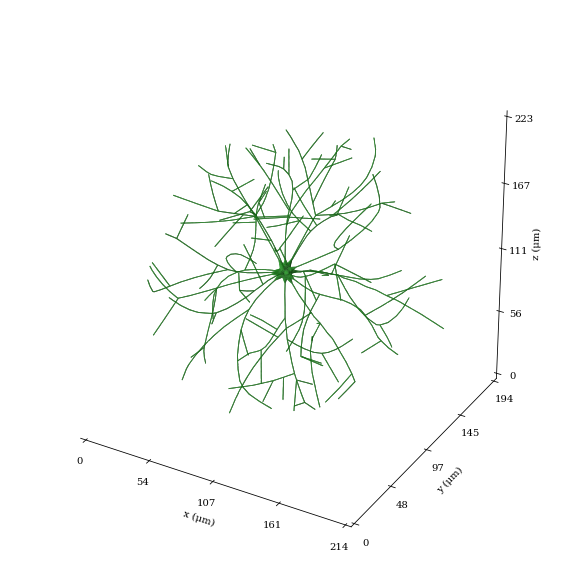

In [6]:
# Load and show the mesh

mesh = meshio.read("neuron-model.ply")
vertices = mesh.points
faces = mesh.cells[0].data

plt.rcParams["font.family"] = "serif"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(
    vertices[:, 0] * 1e6,
    vertices[:, 1] * 1e6,
    vertices[:, 2] * 1e6,
    triangles=faces,
    color="tab:green",
)
ax.set_xlim([0, np.max(vertices, axis=0)[0]])
ax.set_ylim([0, np.max(vertices, axis=0)[1]])
ax.set_zlim([0, np.max(vertices, axis=0)[2]])
ax.set_xticks(np.round(np.linspace(0, np.max(vertices * 1e6, axis=0)[0], 5)))
ax.set_yticks(np.round(np.linspace(0, np.max(vertices * 1e6, axis=0)[1], 5)))
ax.set_zticks(np.round(np.linspace(0, np.max(vertices * 1e6, axis=0)[2], 5)))
ax.set_xlabel("x (μm)")
ax.set_ylabel("y (μm)")
ax.set_zlabel("z (μm)")
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axis._axinfo["grid"]["color"] = (1, 1, 1, 0)
fig.tight_layout()
plt.show()
fig.savefig("figures/mesh.png", dpi=600, bbox_inches="tight", transparent=False)

# Create gradient array

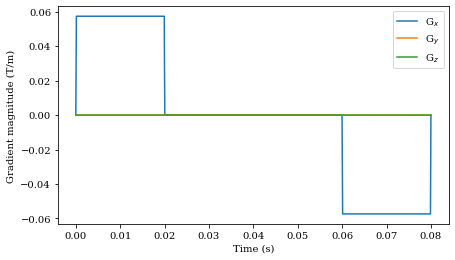

In [7]:
# Define diffusion encoding gradient and save it as a camino scheme file

n_t = int(1e4)
n_m = 11
T = 80e-3
bs = np.linspace(1, 5e9, n_m)
gradient = np.zeros((1, 800, 3))
gradient[0, 1:200, 0] = 1
gradient[0, -200:-1, 0] = -1
dt = T / (gradient.shape[1] - 1)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = np.concatenate([gradient for _ in bs], axis=0)
gradient = gradients.set_b(gradient, dt, bs)

fig, ax = plt.subplots(1, figsize=(7, 4))
for i in range(3):
    ax.plot(np.linspace(0, T, n_t), gradient[-1, :, i])
ax.legend(["G$_x$", "G$_y$", "G$_z$"])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Gradient magnitude (T/m)")
plt.show()

scheme = np.zeros((n_m, 7))
scheme[:, 0] = 1
scheme[:, 3] = np.max(gradient, axis=1)[:, 0]
scheme[:, 4] = 60e-3
scheme[:, 5] = 20e-3
scheme[:, 6] = 81e-3
np.savetxt(
    f"results/pgse.scheme", scheme, header="VERSION: STEJSKALTANNER", comments=""
)

# Calculate initial positions

Aligning the corner of the simulated voxel with the origin
Moved the vertices by [-2.81249985e-13 -1.21582039e-13  3.31542953e-13]
Dividing the mesh into subvoxels


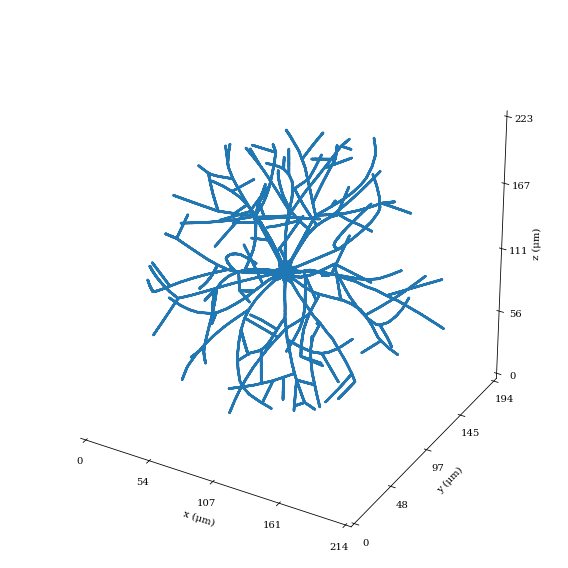

In [8]:
# Calculate initial positions, show them, and save them

n_points = int(1e6)

substrate = substrates.mesh(
    vertices, faces, periodic=True, n_sv=np.array([100, 100, 100])
)
substrate.faces = np.ascontiguousarray(substrate.faces)
substrate.vertices = np.ascontiguousarray(substrate.vertices)

points = simulations._fill_mesh(n_points, substrate, intra=True, seed=123)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    points[:, 0] * 1e6, points[:, 1] * 1e6, points[:, 2] * 1e6, alpha=0.1, s=1
)
ax.set_xlim([0, np.max(vertices, axis=0)[0]])
ax.set_ylim([0, np.max(vertices, axis=0)[1]])
ax.set_zlim([0, np.max(vertices, axis=0)[2]])
ax.set_xticks(np.round(np.linspace(0, np.max(vertices * 1e6, axis=0)[0], 5)))
ax.set_yticks(np.round(np.linspace(0, np.max(vertices * 1e6, axis=0)[1], 5)))
ax.set_zticks(np.round(np.linspace(0, np.max(vertices * 1e6, axis=0)[2], 5)))
ax.set_xlabel("x (μm)")
ax.set_ylabel("y (μm)")
ax.set_zlabel("z (μm)")
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axis._axinfo["grid"]["color"] = (1, 1, 1, 0)
fig.tight_layout()
plt.show()

for i in range(7):
    N = 10 ** i
    np.savetxt(f"results/init_pos_{N}.dat", points[0:N], header=str(N), comments="")

In [9]:
# Run simulations, time them, and save the results

for i in range(7):
    b = time.time()
    n_walkers = int(10 ** i)
    mesh = meshio.read("neuron-model.ply")
    vertices = np.ascontiguousarray(mesh.points)
    faces = np.ascontiguousarray(mesh.cells[0].data)
    init_pos = np.loadtxt(f"results/init_pos_{n_walkers}.dat", skiprows=1)
    if i == 0:
        init_pos = init_pos[np.newaxis]
    substrate = substrates.mesh(
        vertices,
        faces,
        periodic=True,
        n_sv=np.array([100, 100, 100]),
        init_pos=init_pos,
    )
    signals = simulations.simulation(n_walkers, 2e-9, gradient, dt, substrate)
    a = time.time()
    np.savetxt(f"results/disimpy_signals_w{n_walkers}_t{n_t}.txt", signals)
    np.savetxt(f"results/disimpy_runtime_w{n_walkers}_t{n_t}.txt", np.array([a - b]))

Aligning the corner of the simulated voxel with the origin
Moved the vertices by [-2.81249985e-13 -1.21582039e-13  3.31542953e-13]
Dividing the mesh into subvoxels
Finished dividing the mesh into subvoxels
Starting simulation
Number of random walkers = 1
Number of steps = 10000
Step length = 3.1003249859931566e-07 m
Step duration = 8.010012515644555e-06 s
Simulation finished
Aligning the corner of the simulated voxel with the origin
Moved the vertices by [-2.81249985e-13 -1.21582039e-13  3.31542953e-13]
Dividing the mesh into subvoxels
Finished dividing the mesh into subvoxels
Starting simulation
Number of random walkers = 10
Number of steps = 10000
Step length = 3.1003249859931566e-07 m
Step duration = 8.010012515644555e-06 s
Simulation finished
Aligning the corner of the simulated voxel with the origin
Moved the vertices by [-2.81249985e-13 -1.21582039e-13  3.31542953e-13]
Dividing the mesh into subvoxels
Finished dividing the mesh into subvoxels
Starting simulation
Number of random 